# **Project 3D Velodyne points to 2D camera Image** 
***

## Dataset
[KITTI 2011_09_26_drive_0005 dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php?type=city)  
In this code, rectified image is used.

refer to [KITTI Dataset Paper](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf) for the details of data measurement environment

## Objective

Project Velodyne points(model : HDL-64E) to 2D camera Image.  
  

# Process
  
***  

For converting coordinate systems, there are several steps.  
To help your understanding, I made a simple slide. The codes below are proceeding as these steps.  
  
  

In [4]:
path = '/home/KITTI_Tutorial/data/2011_09_26/2011_09_26_drive_0005_sync/'
path = '/home/kk/Downloads/2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/'

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # ignore reflectivity info
    return obj[:,:3]

def load_from_bin_with_reflect(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # Do NOT ignore reflectivity info
    return obj[:,:4]

def add_velo_points_array_with_id(arr_points):
    list_v = list(arr_points)
    i = 0
    list_v_id=[]
    for v in list_v:
        v=np.append(v, i)
        list_v_id.append(v)
        i=i+1
    arr_points_id = np.array(list_v_id).astype(np.float32)
    return arr_points_id

# bin file -> numpy array
velo_points = load_from_bin(path + 'velodyne_points/data/0000000030.bin')
velo_points_with_ref = load_from_bin_with_reflect(path + 'velodyne_points/data/0000000030.bin')   

# Assign id for every 3d points
# velo_points_with_ref.shape    (122516, 4) x, y, z, r
# velo_points_with_ref_id.shape (122516, 5) x, y, z, r, id

velo_points_with_ref_id = add_velo_points_array_with_id(velo_points_with_ref)
assert  velo_points_with_ref_id.shape == (122516, 5)

In [2]:
# We can get ANY things of 3D points (x, y, z, r, dist) if you give me id of 2D point
# dict_bbox[id] = (x, y, z, r, dist)
# dict_bboxes[object_id] = dict_bbox

def getDict3DPoints(arr_velo_points_r_id):
    dict_3Dpoints = {}
    for i, v in np.ndenumerate(arr_velo_points_r_id):
        if i[1] == 4 :
            arr = []
            for n in range(5):
                if   n == 0:
                    x = arr_velo_points_r_id[(i[0] , n)]
                    arr.append(x)
                elif n == 1:
                    y = arr_velo_points_r_id[(i[0] , n)]
                    arr.append(y)
                elif n == 2:
                    z = arr_velo_points_r_id[(i[0] , n)]
                    arr.append(z)
                elif n == 3:
                    r = arr_velo_points_r_id[(i[0] , n)]
                    arr.append(r) 
                else:
                    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)
                    arr.append(dist)
            dict_3Dpoints[arr_velo_points_r_id[i]] = arr
    return dict_3Dpoints
    

dict_3Dpoints = getDict3DPoints(velo_points_with_ref_id)

In [5]:
dict_3Dpoints[122]

[41.1, 16.514, 1.707, 0.41, 44.32646971748926]

(375, 1242, 3)


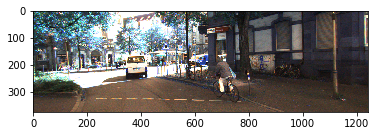

In [6]:
import matplotlib.image as mpimg

#read left camera image
image_type = 'color' # 'grayscale' or 'color' image

mode = '00' if image_type == 'grayscale' else '02' 

image = cv2.imread(path + 'image_'+ mode +'/data/0000000030.png')
width, height = image.shape[1], image.shape[0]

plt.imshow(image)
print(image.shape)

In [9]:
def depth_color(val, min_d=0, max_d=120):
    """ 
    print Color(HSV's H value) corresponding to distance(m) 
    close distance = red , far distance = blue
    """
    np.clip(val, 0, max_d, out=val) # max distance is 120m but usually not usual
    return (((val - min_d) / (max_d - min_d)) * 120).astype(np.uint8) 

def in_h_range_points(points, m, n, fov):
    """ extract horizontal in-range points """
    return np.logical_and(np.arctan2(n,m) > (-fov[1] * np.pi / 180), \
                          np.arctan2(n,m) < (-fov[0] * np.pi / 180))

def in_v_range_points(points, m, n, fov):
    """ extract vertical in-range points """
    return np.logical_and(np.arctan2(n,m) < (fov[1] * np.pi / 180), \
                          np.arctan2(n,m) > (fov[0] * np.pi / 180))

def fov_setting(points, x, y, z, dist, h_fov, v_fov):
    """ filter points based on h,v FOV  """
    
    if h_fov[1] == 180 and h_fov[0] == -180 and v_fov[1] == 2.0 and v_fov[0] == -24.9:
        return points
    
    if h_fov[1] == 180 and h_fov[0] == -180:
        return points[in_v_range_points(points, dist, z, v_fov)]
    elif v_fov[1] == 2.0 and v_fov[0] == -24.9:        
        return points[in_h_range_points(points, x, y, h_fov)]
    else:
        h_points = in_h_range_points(points, x, y, h_fov)
        v_points = in_v_range_points(points, dist, z, v_fov)
    return points[np.logical_and(h_points, v_points)]

def in_range_points(points, size):
    """ extract in-range points """
    return np.logical_and(points > 0, points < size)    

def velo_points_filter(points, v_fov, h_fov):
    """ extract points corresponding to FOV setting """
    
    # Projecting to 2D
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)

    if h_fov[0] < -90:
        h_fov = (-90,) + h_fov[1:]
    if h_fov[1] > 90:
        h_fov = h_fov[:1] + (90,)
    
    x_lim = fov_setting(x, x, y, z, dist, h_fov, v_fov)[:,None]
    y_lim = fov_setting(y, x, y, z, dist, h_fov, v_fov)[:,None]
    z_lim = fov_setting(z, x, y, z, dist, h_fov, v_fov)[:,None]
    print('x_lim', x_lim)
    # Stack arrays in sequence horizontally
    xyz_ = np.hstack((x_lim, y_lim, z_lim))
    xyz_ = xyz_.T

    # stack (1,n) arrays filled with the number 1
    one_mat = np.full((1, xyz_.shape[1]), 1)
    xyz_ = np.concatenate((xyz_, one_mat),axis = 0)

    # need dist info for points color
    dist_lim = fov_setting(dist, x, y, z, dist, h_fov, v_fov)
    color = depth_color(dist_lim, 0, 70)
    
    return xyz_, color

def velo_points_filter_id(points_id, v_fov, h_fov):
    """ extract points corresponding to FOV setting """
    
    # Projecting to 2D
    x = points_id[:, 0]
    y = points_id[:, 1]
    z = points_id[:, 2]
    r = points_id[:, 3]
    ids = points_id[:, 4]

    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)

    if h_fov[0] < -90:
        h_fov = (-90,) + h_fov[1:]
    if h_fov[1] > 90:
        h_fov = h_fov[:1] + (90,)
    
    x_lim = fov_setting(x, x, y, z, dist, h_fov, v_fov)[:,None]
    y_lim = fov_setting(y, x, y, z, dist, h_fov, v_fov)[:,None]
    z_lim = fov_setting(z, x, y, z, dist, h_fov, v_fov)[:,None]
    r_lim = fov_setting(r, x, y, z, dist, h_fov, v_fov)[:,None]
    ids_lim = fov_setting(ids, x, y, z, dist, h_fov, v_fov)[:,None]
    
    # Stack arrays in sequence horizontally
    xyz_ = np.hstack((x_lim, y_lim, z_lim))
    xyz_ = xyz_.T
    
    xyzri_ = np.hstack((x_lim, y_lim, z_lim))
    xyzri_ = xyzri_.T
    
    # stack (1,n) arrays filled with the number 1
    one_mat = np.full((1, xyz_.shape[1]), 1)
    
    xyz_   = np.concatenate((xyz_, one_mat)  ,axis = 0)
    xyzri_ = np.concatenate((xyzri_, one_mat),axis = 0)
    xyzri_ = np.concatenate((xyzri_, r_lim.T),axis = 0)  
    xyzri_ = np.concatenate((xyzri_, ids_lim.T),axis = 0)
    
    # need dist info for points color
    dist_lim = fov_setting(dist, x, y, z, dist, h_fov, v_fov)
    print('dist_lim', dist_lim)
    color = depth_color(dist_lim, 0, 70)
    
    return xyz_, color, xyzri_ 

In [8]:
# For test
points = velo_points   
v_fov  = (-24.9, 2.0)
h_fov  = (-45,45)
print(points.shape)
print(points[0])
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]
print(x.shape) # (122516, )

dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)
print(dist.shape) # (122516, )
print(h_fov[1:])

x_lim = fov_setting(x, x, y, z, dist, h_fov, v_fov)[:,None]
y_lim = fov_setting(y, x, y, z, dist, h_fov, v_fov)[:,None]
z_lim = fov_setting(z, x, y, z, dist, h_fov, v_fov)[:,None]
print(x_lim.shape)
xyz_ = np.hstack((x_lim, y_lim, z_lim))
xyz_ = xyz_.T
print(xyz_.shape)

one_mat = np.full((1, xyz_.shape[1]), 1)
xyz_.shape[1]
print(one_mat.shape)

xyz_ = np.concatenate((xyz_, one_mat),axis = 0)
print(xyz_.shape)
print(xyz_[:,30])

(122516, 3)
[5.7174e+01 2.7000e-02 2.1420e+00]
(122516,)
(122516,)
(45,)
(32062, 1)
(3, 32062)
(1, 32062)
(4, 32062)
[42.92499924  4.00400019  1.66700006  1.        ]


In [10]:
# For test
points_id = velo_points_with_ref_id   
v_fov  = (-24.9, 2.0)
h_fov  = (-45,45)
xyz_, color, xyzri_ = velo_points_filter_id(points_id, v_fov, h_fov)
# print(xyzri_[2])
# print(z_lim)
# print(z)
points_id.shape
print(color)

dist_lim [57.214115  57.312313  57.666176  ...  4.3818727  4.4036036  4.422075 ]
[98 98 98 ...  7  7  7]


In [11]:
v2c_filepath = '/home/KITTI_Tutorial/data/2011_09_26/calib_velo_to_cam.txt'
c2c_filepath = '/home/KITTI_Tutorial/data/2011_09_26/calib_cam_to_cam.txt'

v2c_filepath = '/home/kk/Downloads/2011_09_26_calib/2011_09_26/calib_velo_to_cam.txt'
c2c_filepath = '/home/kk/Downloads/2011_09_26_calib/2011_09_26/calib_cam_to_cam.txt'

In [12]:
# For test
print(velo_points.shape)
print(velo_points_with_ref.shape)
print(velo_points_with_ref[0])
print(velo_points_with_ref[6])
print(velo_points_with_ref[-3])
xyz_, color, xyzri_ = velo_points_filter_id(velo_points_with_ref_id, v_fov=(-24.9, 2.0), h_fov=(-45,45))
print(type(xyz_))
print(xyz_.shape)  # (4, 32062)  x, y, z, 1
print(color.shape) # (32062,)   
print(xyzri_.shape)# (6, 32062)  x, y, z, 1, r, id 
print(xyzri_[4, :])

(122516, 3)
(122516, 4)
[5.7174e+01 2.7000e-02 2.1420e+00 0.0000e+00]
[5.8502e+01 1.2240e+00 2.1880e+00 4.0000e-02]
[ 3.757 -1.415 -1.756  0.36 ]
dist_lim [57.214115  57.312313  57.666176  ...  4.3818727  4.4036036  4.422075 ]
<class 'numpy.ndarray'>
(4, 32062)
(32062,)
(6, 32062)
[0.         0.         0.         ... 0.36000001 0.         0.        ]


In [13]:
def calib_velo2cam(filepath):
    """ 
    get Rotation(R : 3x3), Translation(T : 3x1) matrix info 
    using R,T matrix, we can convert velodyne coordinates to camera coordinates
    """
    with open(filepath, "r") as f:
        file = f.readlines()    
        
        for line in file:
            (key, val) = line.split(':',1)
            if key == 'R':
                R = np.fromstring(val, sep=' ')
                R = R.reshape(3, 3)
            if key == 'T':
                T = np.fromstring(val, sep=' ')
                T = T.reshape(3, 1)
    return R, T

def calib_cam2cam(filepath, mode):
    """
    If your image is 'rectified image' :
        get only Projection(P : 3x4) matrix is enough
    but if your image is 'distorted image'(not rectified image) :
        you need undistortion step using distortion coefficients(5 : D)
        
    in this code, I'll get P matrix since I'm using rectified image
    """
    with open(filepath, "r") as f:
        file = f.readlines()
        
        for line in file:
            (key, val) = line.split(':',1)
            if key == ('P_rect_' + mode):
                P_ = np.fromstring(val, sep=' ')
                P_ = P_.reshape(3, 4)
                # erase 4th column ([0,0,0])
                P_ = P_[:3, :3]
    return P_
 
def velo3d_2_camera2d_points(points, v_fov, h_fov, vc_path, cc_path, mode='02'):
    """ print velodyne 3D points corresponding to camera 2D image """
    
    # R_vc = Rotation matrix ( velodyne -> camera )
    # T_vc = Translation matrix ( velodyne -> camera )
    R_vc, T_vc = calib_velo2cam(vc_path)
    
    # P_ = Projection matrix ( camera coordinates 3d points -> image plane 2d points )
    P_ = calib_cam2cam(cc_path, mode)

    """
    xyz_v - 3D velodyne points corresponding to h, v FOV in the velodyne coordinates
    c_    - color value(HSV's Hue) corresponding to distance(m)
    
             [x_1 , x_2 , .. ]
    xyz_v =  [y_1 , y_2 , .. ]   
             [z_1 , z_2 , .. ]
             [ 1  ,  1  , .. ]
    """  
    #xyz_v, c_ = velo_points_filter(points, v_fov, h_fov)
    xyz_v, c_, xyzri_v = velo_points_filter_id(points, v_fov, h_fov)
    #print(xyzri_v.shape)

    """
    RT_ - rotation matrix & translation matrix
        ( velodyne coordinates -> camera coordinates )
    
            [r_11 , r_12 , r_13 , t_x ]
    RT_  =  [r_21 , r_22 , r_23 , t_y ]   
            [r_31 , r_32 , r_33 , t_z ]
    """
    RT_ = np.concatenate((R_vc, T_vc),axis = 1)
    
    # convert velodyne coordinates(X_v, Y_v, Z_v) to camera coordinates(X_c, Y_c, Z_c) 
    for i in range(xyz_v.shape[1]):
        xyz_v[:3,i]    = np.matmul(RT_, xyz_v[:4,i])
        xyzri_v[:3, i] = np.matmul(RT_, xyzri_v[:4,i])
    #print(xyzri_v.shape)
    """
    xyz_c - 3D velodyne points corresponding to h, v FOV in the camera coordinates
             [x_1 , x_2 , .. ]
    xyz_c =  [y_1 , y_2 , .. ]   
             [z_1 , z_2 , .. ]
    """ 
    xyz_c = np.delete(xyz_v, 3, axis=0)
     
    # convert camera coordinates(X_c, Y_c, Z_c) image(pixel) coordinates(x,y) 
    for i in range(xyz_c.shape[1]):
        xyz_c[:,i]    = np.matmul(P_, xyz_c[:,i])    
        xyzri_v[:3,i] = np.matmul(P_, xyzri_v[:3,i])
    #print(xyzri_v.shape)
    """
    xy_i - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates before scale adjustment
    ans  - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates
             [s_1*x_1 , s_2*x_2 , .. ]
    xy_i =   [s_1*y_1 , s_2*y_2 , .. ]        ans =   [x_1 , x_2 , .. ]  
             [  s_1   ,   s_2   , .. ]                [y_1 , y_2 , .. ]
    """
    xy_i = xyz_c[::]/xyz_c[::][2]
    ans = np.delete(xy_i, 2, axis=0)
    
    xyri_i = xyzri_v[:2]/xyzri_v[::][2]
    xyzri_v[:2] = xyri_i
    ans_ri = xyzri_v 
    #print(ans_ri.shape)

    """
    width = 1242
    height = 375
    w_range = in_range_points(ans[0], width)
    h_range = in_range_points(ans[1], height)

    ans_x = ans[0][np.logical_and(w_range,h_range)][:,None].T
    ans_y = ans[1][np.logical_and(w_range,h_range)][:,None].T
    c_ = c_[np.logical_and(w_range,h_range)]

    ans = np.vstack((ans_x, ans_y))
    """
    
    return ans, c_, ans_ri

In [14]:
cc_path = c2c_filepath
P_ = calib_cam2cam(cc_path, mode)
P_

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [15]:
arr_2Dpoints_xyz_, c_ , arr_2Dpoints_xyzri_= velo3d_2_camera2d_points(velo_points_with_ref_id, v_fov=(-24.9, 2.0), h_fov=(-45,45), \
                               vc_path=v2c_filepath, cc_path=c2c_filepath, mode=mode)
# print('***')
# print(arr_2Dpoints_xyz_.shape)    
# print(arr_2Dpoints_xyzri_.shape)
# print(arr_2Dpoints_xyzri_[:2])
# print('-'*20)
# print(arr_2Dpoints_xyzri_[5])
# print('-'*20)
#print(arr_2Dpoints_xyzri_[:])
# print(c_)
# print(len(c_))

# arr_2Dpoints_xyz_    # x y   
# arr_2Dpoints_xyzri_  # x y s 1 r id  

dist_lim [57.214115  57.312313  57.666176  ...  4.3818727  4.4036036  4.422075 ]


# Choose a box 

In [16]:
# Judge 2D points inside bbox

def point_in_bbox_or_not(point, bbox):
    if bbox.x < point[0] < bbox.x + bbox.w and \
       bbox.y < point[1] < bbox.y + bbox.h:
           return True  
    else:
           return False
    
class BoundingBox:
    def __init__(self, imageName, classId, x, y, w, h, imgSize):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self._2DpointsId = []    
        
# dict_2Dpoints # KEY = ID, VALUE = (X, Y) , all 2D points
dict_r_FOV = {}
dict_dist_FOV = {}
dict_2Dpoints_FOV = {} 
id_list = []
id_list = arr_2Dpoints_xyzri_[5]
for idx, iid in enumerate(id_list):
    dict_2Dpoints_FOV[iid] = list()
    dict_dist_FOV[iid] = list()
    dict_r_FOV[iid] = list()
    dict_2Dpoints_FOV[iid].append([arr_2Dpoints_xyzri_[0, idx], arr_2Dpoints_xyzri_[1, idx]])
    dict_dist_FOV[iid].append([dict_3Dpoints[iid][4]])
    #print([dict_3Dpoints[iid][3]])
    dict_r_FOV[iid].append([dict_3Dpoints[iid][3]])   
#print(len(dict_dist_FOV))
#print(dict_dist_FOV)

# pole_bbox=BoundingBox(1085, 1085+77,1, 1+329)
# tree1_bbox=BoundingBox(556, 556+32, 2, 2+252)
# cyclist_bbox=BoundingBox(662, 662+104, 174, 174+168)
# tree2_bbox=BoundingBox(155, 155+33, 88, 88+138)

boxes = []
boxes.append(BoundingBox('cyclist_bbox', 1, 662, 174, 104, 168, (10, 10)))    # cyclist_bbox
# boxes.append(BoundingBox('pole_bbox', 1, 1085, 1, 77, 329, (10, 10)))         # pole_bbox 
# boxes.append(BoundingBox('tree1_bbox', 1, 556, 2, 32, 252, (10, 10)))         # tree1_bbox
# boxes.append(BoundingBox('tree2_bbox', 1, 155, 88, 33, 138, (10, 10)))        # tree2_bbox


for inx, iid in enumerate(dict_2Dpoints_FOV):
    for box in boxes:
        p = dict_2Dpoints_FOV[iid][0]
        #print(p)
        if point_in_bbox_or_not(p, box):
                box._2DpointsId.append(iid)
                
print(len(box._2DpointsId))
print(type(box._2DpointsId))
# print((box._2DpointsId))

1584
<class 'list'>


In [18]:
# dict_2Dpoints_FOV_Box  (u, v) 
cnt = 0
dict_2Dpoints_FOV_Box = {}
for iid in box._2DpointsId:
    #print(iid)
    cnt = cnt + 1
    dict_2Dpoints_FOV_Box[iid] = dict_2Dpoints_FOV[iid]
#print((dict_2Dpoints_FOV_Box))

#dict_dist_FOV_Box
dict_dist_FOV_Box = {}
for iid in box._2DpointsId:
    dict_dist_FOV_Box[iid] = dict_dist_FOV[iid]
print(len(dict_dist_FOV_Box))

#dict_dist_FOV_Box
dict_r_FOV_Box = {}
for iid in box._2DpointsId:
    dict_r_FOV_Box[iid] = dict_r_FOV[iid]
print(len(dict_r_FOV_Box))

list_2Dpoints_Box = []
list_dist_Box     = []
list_r_Box        = []
for iid in box._2DpointsId:
    list_2Dpoints_Box.append(dict_2Dpoints_FOV_Box[iid])
    list_dist_Box.append(dict_dist_FOV_Box[iid])
    list_r_Box.append(dict_r_FOV_Box[iid])
    
    
arr_2Dpoints_Box = np.array(list_2Dpoints_Box)
arr_dist_Box     = np.array(list_dist_Box)
arr_r_Box        = np.array(list_r_Box) 
len(arr_2Dpoints_Box)
#(arr_r_Box)

1584
1584


1584

In [15]:
# for iid in box._2DpointsId:
#     print(dict_dist_FOV_Box[iid][0][0])

In [19]:
n_points = len(arr_2Dpoints_Box)
print(n_points)

1584


(1584,)
694
(1584,)


<Figure size 576x432 with 0 Axes>

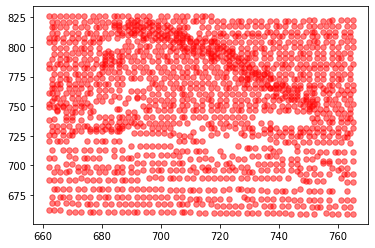

<Figure size 576x432 with 0 Axes>

In [20]:
from matplotlib import pyplot as plt

cnt = 0
list_x = []
list_y = []
list_cnt = []
for iid in box._2DpointsId:
    x = np.int32(dict_2Dpoints_FOV_Box[iid][0][0])
    y = np.int32(dict_2Dpoints_FOV_Box[iid][0][1])
    #print(x)
    list_x.append(x)
    list_y.append(y)
    cnt = cnt + 1
    list_cnt.append(cnt)
    
arr_x = np.array(list_x)
arr_y = np.array(list_y)
arr_cnt = np.array(list_cnt)

print(arr_x.shape)
print(arr_x[10])
print(arr_cnt.shape)
plt.scatter(arr_x[:], 1000 - arr_y[:], s=30, c='red',marker='o',alpha=0.5,label='C1')
plt.figure(figsize=(8,6))
# plt.title('basic scatter plot ')
# plt.xlabel('variables x')
# plt.ylabel('variables y')
# plt.legend(loc='upper right')

In [21]:
def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def depth_color(val, min_d=0, max_d=120):
    """ 
    print Color(HSV's H value) corresponding to distance(m) 
    close distance = red , far distance = blue
    """
    np.clip(val, 0, max_d, out=val) # max distance is 120m but usually not usual
    return (((val - min_d) / (max_d - min_d)) * 120).astype(np.uint8) 

image_type = 'color' # 'grayscale' or 'color' image
mode = '00' if image_type == 'grayscale' else '02' # image_00 = 'grayscale image' , image_02 = 'color image'
image_c = cv2.imread(path +'image_'+ mode +'/data/0000000030.png')

hsv_image = cv2.cvtColor(image_c, cv2.COLOR_BGR2HSV)
arr_2Dpoints_Box = arr_2Dpoints_Box.reshape(len(arr_2Dpoints_Box), 2)
arr_dist_Box     = arr_dist_Box.reshape(len(arr_2Dpoints_Box), )
arr_dist_Box.shape
c = depth_color(arr_dist_Box, min_d=0, max_d=70)
print(arr_dist_Box[0])
print(c[0])
cnt = 0 
for iid in range(arr_2Dpoints_Box.shape[0]):
    #print(arr_2Dpoints_Box.shape)
    #print(c[iid])
    
    x = np.int32(arr_2Dpoints_Box[iid][0])
    y = np.int32(arr_2Dpoints_Box[iid][1])
    cv2.circle(hsv_image, (x, y), 2, (int(arr_dist_Box[iid]),255,255),-1)
    
cnt = 0
for iid in box._2DpointsId:
    x = np.int32(dict_2Dpoints_FOV_Box[iid][0][0])
    y = np.int32(dict_2Dpoints_FOV_Box[iid][0][1])
    #text = str(dict_dist_FOV_Box[iid])
    if cnt%1 == 0:
        #cv2.putText(hsv_image, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, cv2.LINE_AA)
        print('-'*10)
        print('coord =', (x, y))
        f = dict_dist_FOV_Box[iid][0][0]
        print('Distance:%.2f' % f)
        r = dict_r_FOV_Box[iid][0][0]
        print('Refl:%.2f'% r)
        print('-'*10)
        cv2.circle(hsv_image, (x, y), 4, (255, 255, 255), -1)
    cnt = cnt + 1

# cnt = 0
# for iid in range(arr_2Dpoints_Box.shape[0]):    
#     x = np.int32(arr_2Dpoints_Box[iid][0])
#     y = np.int32(arr_2Dpoints_Box[iid][1])
#     text = str(c[iid])
#     if cnt%100 == 0:
#         #cv2.putText(hsv_image, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, cv2.LINE_AA)
#         print('coor = ', (x, y))
#         print('Distance:', c[iid])
#         cv2.circle(hsv_image, (x, y), 4, (255, 255, 255), -1)
#     cnt = cnt + 1
    
image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

# f = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)    
# plt.imshow(f)
# print(f.shape)

19.42916739890072
33
----------
coord = (717, 174)
Distance:19.43
Refl:0.31
----------
----------
coord = (715, 174)
Distance:19.48
Refl:0.34
----------
----------
coord = (714, 174)
Distance:19.53
Refl:0.33
----------
----------
coord = (712, 174)
Distance:19.59
Refl:0.20
----------
----------
coord = (709, 174)
Distance:19.65
Refl:0.48
----------
----------
coord = (707, 174)
Distance:19.79
Refl:0.32
----------
----------
coord = (705, 174)
Distance:19.73
Refl:0.56
----------
----------
coord = (702, 174)
Distance:19.85
Refl:0.00
----------
----------
coord = (700, 174)
Distance:19.94
Refl:0.00
----------
----------
coord = (696, 174)
Distance:20.10
Refl:0.23
----------
----------
coord = (694, 174)
Distance:20.32
Refl:0.39
----------
----------
coord = (692, 174)
Distance:20.62
Refl:0.20
----------
----------
coord = (689, 174)
Distance:20.94
Refl:0.19
----------
----------
coord = (687, 174)
Distance:20.11
Refl:0.27
----------
----------
coord = (685, 174)
Distance:20.00
Refl:0.39


----------
----------
coord = (740, 196)
Distance:18.47
Refl:0.35
----------
----------
coord = (738, 196)
Distance:18.52
Refl:0.34
----------
----------
coord = (737, 196)
Distance:18.55
Refl:0.37
----------
----------
coord = (734, 196)
Distance:18.58
Refl:0.33
----------
----------
coord = (732, 196)
Distance:18.64
Refl:0.34
----------
----------
coord = (730, 196)
Distance:18.67
Refl:0.37
----------
----------
coord = (727, 196)
Distance:18.71
Refl:0.32
----------
----------
coord = (725, 196)
Distance:18.76
Refl:0.34
----------
----------
coord = (723, 196)
Distance:18.80
Refl:0.34
----------
----------
coord = (721, 196)
Distance:18.84
Refl:0.42
----------
----------
coord = (719, 196)
Distance:19.12
Refl:0.31
----------
----------
coord = (717, 196)
Distance:19.16
Refl:0.36
----------
----------
coord = (714, 196)
Distance:19.17
Refl:0.30
----------
----------
coord = (712, 196)
Distance:19.20
Refl:0.32
----------
----------
coord = (710, 196)
Distance:19.21
Refl:0.27
----------

----------
coord = (714, 199)
Distance:7.79
Refl:0.23
----------
----------
coord = (712, 199)
Distance:7.76
Refl:0.33
----------
----------
coord = (711, 199)
Distance:7.78
Refl:0.22
----------
----------
coord = (708, 199)
Distance:7.77
Refl:0.28
----------
----------
coord = (706, 199)
Distance:7.76
Refl:0.28
----------
----------
coord = (703, 199)
Distance:7.76
Refl:0.32
----------
----------
coord = (701, 199)
Distance:7.75
Refl:0.34
----------
----------
coord = (699, 199)
Distance:7.75
Refl:0.35
----------
----------
coord = (696, 199)
Distance:7.77
Refl:0.27
----------
----------
coord = (695, 199)
Distance:7.77
Refl:0.27
----------
----------
coord = (693, 199)
Distance:7.79
Refl:0.29
----------
----------
coord = (690, 199)
Distance:7.79
Refl:0.26
----------
----------
coord = (688, 199)
Distance:7.77
Refl:0.16
----------
----------
coord = (686, 214)
Distance:19.55
Refl:0.11
----------
----------
coord = (683, 214)
Distance:19.52
Refl:0.24
----------
----------
coord = (681

----------
coord = (720, 221)
Distance:7.69
Refl:0.30
----------
----------
coord = (718, 221)
Distance:7.69
Refl:0.37
----------
----------
coord = (715, 221)
Distance:7.68
Refl:0.34
----------
----------
coord = (713, 221)
Distance:7.67
Refl:0.28
----------
----------
coord = (712, 221)
Distance:7.67
Refl:0.39
----------
----------
coord = (709, 221)
Distance:7.68
Refl:0.39
----------
----------
coord = (707, 221)
Distance:7.69
Refl:0.32
----------
----------
coord = (704, 221)
Distance:7.71
Refl:0.40
----------
----------
coord = (702, 221)
Distance:7.73
Refl:0.31
----------
----------
coord = (700, 221)
Distance:7.76
Refl:0.34
----------
----------
coord = (697, 221)
Distance:7.78
Refl:0.24
----------
----------
coord = (696, 221)
Distance:7.83
Refl:0.31
----------
----------
coord = (694, 221)
Distance:7.85
Refl:0.52
----------
----------
coord = (691, 221)
Distance:7.81
Refl:0.28
----------
----------
coord = (689, 221)
Distance:7.84
Refl:0.40
----------
----------
coord = (686, 

----------
coord = (740, 245)
Distance:7.71
Refl:0.53
----------
----------
coord = (738, 245)
Distance:7.73
Refl:0.24
----------
----------
coord = (735, 245)
Distance:7.69
Refl:0.20
----------
----------
coord = (733, 245)
Distance:7.68
Refl:0.35
----------
----------
coord = (732, 245)
Distance:7.66
Refl:0.33
----------
----------
coord = (729, 245)
Distance:7.65
Refl:0.36
----------
----------
coord = (727, 245)
Distance:7.63
Refl:0.32
----------
----------
coord = (725, 245)
Distance:7.63
Refl:0.36
----------
----------
coord = (722, 245)
Distance:7.64
Refl:0.36
----------
----------
coord = (720, 245)
Distance:7.62
Refl:0.36
----------
----------
coord = (717, 245)
Distance:7.63
Refl:0.35
----------
----------
coord = (716, 244)
Distance:7.63
Refl:0.36
----------
----------
coord = (714, 245)
Distance:7.63
Refl:0.34
----------
----------
coord = (711, 245)
Distance:7.63
Refl:0.37
----------
----------
coord = (709, 244)
Distance:7.65
Refl:0.34
----------
----------
coord = (707, 

coord = (710, 275)
Distance:11.56
Refl:0.36
----------
----------
coord = (708, 275)
Distance:11.59
Refl:0.34
----------
----------
coord = (706, 274)
Distance:11.59
Refl:0.34
----------
----------
coord = (703, 274)
Distance:11.59
Refl:0.20
----------
----------
coord = (703, 268)
Distance:8.05
Refl:0.54
----------
----------
coord = (701, 268)
Distance:8.01
Refl:0.48
----------
----------
coord = (699, 268)
Distance:8.02
Refl:0.46
----------
----------
coord = (697, 268)
Distance:8.01
Refl:0.52
----------
----------
coord = (694, 267)
Distance:8.01
Refl:0.52
----------
----------
coord = (692, 267)
Distance:8.02
Refl:0.54
----------
----------
coord = (689, 267)
Distance:8.03
Refl:0.56
----------
----------
coord = (687, 268)
Distance:8.30
Refl:0.00
----------
----------
coord = (686, 268)
Distance:8.44
Refl:0.00
----------
----------
coord = (683, 269)
Distance:8.48
Refl:0.00
----------
----------
coord = (681, 269)
Distance:8.52
Refl:0.00
----------
----------
coord = (678, 269)
Di

coord = (711, 311)
Distance:8.05
Refl:0.16
----------
----------
coord = (709, 311)
Distance:8.01
Refl:0.27
----------
----------
coord = (706, 311)
Distance:8.01
Refl:0.23
----------
----------
coord = (704, 311)
Distance:8.02
Refl:0.23
----------
----------
coord = (703, 311)
Distance:8.04
Refl:0.10
----------
----------
coord = (700, 311)
Distance:8.07
Refl:0.14
----------
----------
coord = (698, 310)
Distance:8.10
Refl:0.24
----------
----------
coord = (696, 311)
Distance:8.16
Refl:0.10
----------
----------
coord = (692, 312)
Distance:9.43
Refl:0.16
----------
----------
coord = (690, 312)
Distance:9.43
Refl:0.04
----------
----------
coord = (688, 312)
Distance:9.39
Refl:0.07
----------
----------
coord = (687, 312)
Distance:9.38
Refl:0.04
----------
----------
coord = (684, 312)
Distance:9.43
Refl:0.07
----------
----------
coord = (682, 312)
Distance:9.41
Refl:0.04
----------
----------
coord = (679, 312)
Distance:9.43
Refl:0.07
----------
----------
coord = (677, 312)
Distan

BoundingBox(ixmin=1085, ixmax=1162, iymin=1, iymax=330)
(329, 77)
<bound method BoundingBox.as_artist of BoundingBox(ixmin=1085, ixmax=1162, iymin=1, iymax=330)>


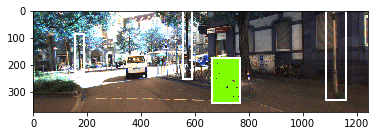

In [22]:
# load bbox [x ,y, w, h]
from photutils import BoundingBox
pole_bbox=BoundingBox(1085, 1085+77,1, 1+329)
tree1_bbox=BoundingBox(556, 556+32, 2, 2+252)
cyclist_bbox=BoundingBox(662, 662+104, 174, 174+168)
tree2_bbox=BoundingBox(155, 155+33, 88, 88+138)
print(pole_bbox)
print(pole_bbox.shape) # h, w
print(pole_bbox.as_artist) 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)
ax.add_patch(pole_bbox.as_artist(facecolor='none', edgecolor='white', lw=2.))
ax.add_patch(tree1_bbox.as_artist(facecolor='none', edgecolor='white', lw=2.))
ax.add_patch(cyclist_bbox.as_artist(facecolor='none', edgecolor='white', lw=2.))
ax.add_patch(tree2_bbox.as_artist(facecolor='none', edgecolor='white', lw=2.))

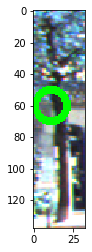

In [23]:
image_c = cv2.imread(path +'image_'+ mode +'/data/0000000030.png')
hsv_image_new = cv2.cvtColor(image_c, cv2.COLOR_BGR2HSV)
image_new = cv2.cvtColor(hsv_image_new, cv2.COLOR_HSV2BGR)

###
coord = (166, 148)
Distance:39.79
Refl:0.16
###
cv2.circle(image_new, coord , 10, (0, 255, 0), 3)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
# ax.imshow(image_new[cyclist_bbox.iymin:cyclist_bbox.iymax,cyclist_bbox.ixmin:cyclist_bbox.ixmax])
# ax.imshow(image_new[pole_bbox.iymin:pole_bbox.iymax,pole_bbox.ixmin:pole_bbox.ixmax])
# ax.imshow(image_new[tree1_bbox.iymin:tree1_bbox.iymax,tree1_bbox.ixmin:tree1_bbox.ixmax])
ax.imshow(image_new[tree2_bbox.iymin:tree2_bbox.iymax,tree2_bbox.ixmin:tree2_bbox.ixmax])

<class 'list'>
20.937454102902105
7.489749879800175
bins 396
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
14
7.967720680154114
<class 'numpy.ndarray'>
7.967720680154114
7.763967585864691
7.730008736816453
8.00167952920235


(0.0, 60.0)

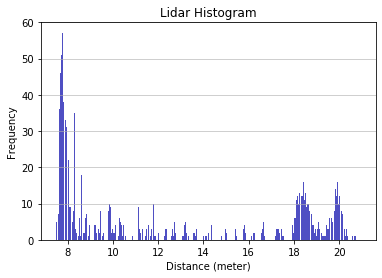

In [26]:
# Find distance of 3D points from 2D points id
dist_list = []
r_list = []
print(type(dist_list))
for iid in box._2DpointsId:
    #print(dict_3Dpoints[iid][4])
    dist_list.append(dict_3Dpoints[iid][4])
    r_list.append(dict_3Dpoints[iid][3])
    # (x, y, z, r, dist)

    
dist_arr = np.array(dist_list)
dist_arr
print(max(dist_list))
print(min(dist_list))
hist, bin_edges = np.histogram(dist_arr)
hist
len(dist_list)
#len(bin_edges)

import matplotlib.pyplot as plt

bins = int(n_points/4)
print('bins', bins)
n, bins, patches = plt.hist(x=dist_arr, bins=bins, color='#0504aa', alpha=0.7, rwidth=0.85)
# n       : Number of same value
# bins    : Value we care. Distance here.
# patches : e.g. Rectangle(xy=(8.66794, 0), width=0.0378259, height=5, angle=0)

print('xxx'*10)
#print(n)
#print((bins))
#print((patches))
print(np.argmax(n))                     # index of max value
print((patches[np.argmax(n)].xy[0]))    # convert index to value 
topk = n.argsort()[-4:][::-1]
print(type(topk))

top0_dist = patches[topk[0]].xy[0]
top1_dist = patches[topk[1]].xy[0]
top2_dist = patches[topk[2]].xy[0]
top3_dist = patches[topk[3]].xy[0]
print((top0_dist))
print((top1_dist))
print((top2_dist))
print((top3_dist))

# if top 0~3 are all close 





plt.grid(axis='y', alpha=0.75)
plt.xlabel('Distance (meter)')
plt.ylabel('Frequency')
plt.title('Lidar Histogram')

#plt.text(23, 45, r'$\mu=15, b=3$')

maxfreq = n.max()
#plt.xlim(xmin=0)
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10  if maxfreq % 10 else maxfreq + 100)

In [32]:
# if top 0~3 are  NOT all close
print((top0_dist))
print((top1_dist))
print((top2_dist))
print((top3_dist))

#uvd_list
#top0_dist_int = int(top0_dist)
d0 = top1_dist
#print(top0_dist_int)

for u, v, d in uvd_list:
    if abs(d - d0) < 0.001:
        #print(abs(d - d0))
        print(u,v,d)
        

7.967720680154114
7.763967585864691
7.730008736816453
8.00167952920235
712.2614145388535 199.41462831004674 7.764413346856289
693.4386460438245 217.37448408293216 7.764743556514172
733.7657360888057 221.93985436776094 7.763616038467127
736.0677515940785 241.00435528351244 7.763986745981738
701.316563877155 249.6034700286568 7.763066650355794


In [31]:
# Test to get top-k elements 
import numpy as np
arr = np.array([1, 3, 2, 4, 5])
arr.argsort()[-3:][::-1]
print(n.argsort()[-3:][::-1])
print(n)
# print(n[78])
# print(n[2])
# print(n[76])
uvd_list

[25  7 26]
[ 6.  0.  9.  1.  0.  0.  2. 42.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.
  2.  0.  0.  0.  0.  0.  2. 52. 34. 14.  3.  1.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  2.]


[[186.68967676756685, 149.48194912652798, 40.22371944905347],
 [185.16289602756385, 149.44531821325575, 40.19232971693822],
 [182.08058403384354, 149.36061211489886, 40.117339220739446],
 [178.49505734314383, 148.20765321214546, 34.04170011719752],
 [175.38606999662747, 148.12411057486446, 34.0480837948237],
 [172.7701766823252, 149.14362868619648, 39.93980481259441],
 [169.6625212970604, 149.06993393406734, 39.880087797066544],
 [166.52318559735664, 148.98808355832858, 39.787990118308244],
 [164.9436371728971, 148.96594683645412, 39.7514976593455],
 [161.76792773912797, 148.88838009232725, 39.66581901491084],
 [158.61626618424071, 148.81221820831163, 39.630282694072534],
 [155.43341459359075, 148.7414108898563, 39.57762323951759],
 [187.34640794306083, 154.8141339189156, 40.19865921501291],
 [184.28584795898368, 154.74805702400695, 40.034491481235435],
 [182.02898790493919, 153.6403931336814, 34.09023779943382],
 [178.93111819830457, 153.57943684576296, 34.05536835692134],
 [175.83515

7.903266784660559


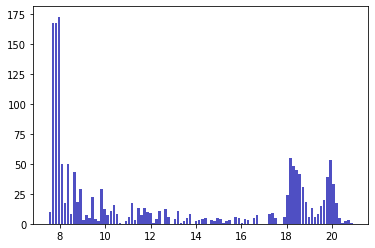

In [28]:
# Function get_dist_from_box
# input   : box, dict_3Dpoints # (x, y, z, r, dist)
# output  : distance estimated
# uvd_list (u, v, dist)
# uvd_dict key: dist, value: (u, v)

def get_uv_dist_from_box(box, dict_3Dpoints, dict_2Dpoints_FOV_Box):
    uv_list   = []
    uvd_list  = []
    #print(type(dist_list))
    dist_list = []
    r_list = []
    for iid in box._2DpointsId:
        temp_uvd = []
        #print((dict_2Dpoints_FOV_Box[iid][0]))
        #print(dict_3Dpoints[iid][4])
        temp_uvd = [dict_2Dpoints_FOV_Box[iid][0][0], dict_2Dpoints_FOV_Box[iid][0][1],dict_3Dpoints[iid][4]]
        #print(temp_uvd)
        uvd_list.append(temp_uvd)
        
        dist_list.append(dict_3Dpoints[iid][4])
        r_list.append(dict_3Dpoints[iid][3])
        
    dist_arr = np.array(dist_list)
    uvd_arr = np.array(uvd_list)
    n, bins, patches = plt.hist(x=dist_arr, bins=100, color='#0504aa', alpha=0.7, rwidth=0.85)
    print(patches[np.argmax(n)].xy[0])
    dist = patches[np.argmax(n)].xy[0]
    return dist, uvd_list


a, uvd_list = get_uv_dist_from_box(box, dict_3Dpoints, dict_2Dpoints_FOV_Box)
#a

In [29]:
# Spatial analysis
print(uvd_list[0])
len(uvd_list)
# for u,v,d in uvd_list:
#     print(u)
#     print(v)
#     print(d)        

[717.9675752997465, 174.01619817031377, 19.42916739890072]


1584

(0.0, 110.0)

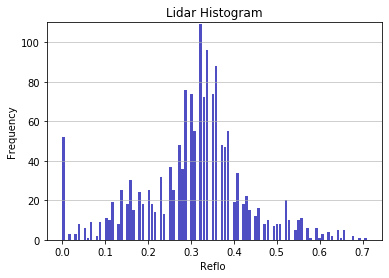

In [33]:
r_arr = np.array(r_list)   
hist, bin_edges = np.histogram(r_arr)
n, bins, patches = plt.hist(x=r_arr, bins=100, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

plt.xlabel('Reflo ')
plt.ylabel('Frequency')
plt.title('Lidar Histogram')

#plt.text(23, 45, r'$\mu=15, b=3$')

maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10  if maxfreq % 10 else maxfreq + 100)

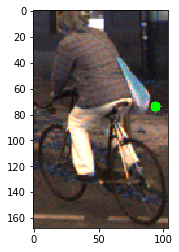

In [34]:
image_c = cv2.imread(path +'image_'+ mode +'/data/0000000030.png')
hsv_image_new = cv2.cvtColor(image_c, cv2.COLOR_BGR2HSV)
image_new = cv2.cvtColor(hsv_image_new, cv2.COLOR_HSV2BGR)

cv2.circle(image_new, (756, 248) , 4, (0, 255, 0), -1)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image_new[cyclist_bbox.iymin:cyclist_bbox.iymax,cyclist_bbox.ixmin:cyclist_bbox.ixmax])

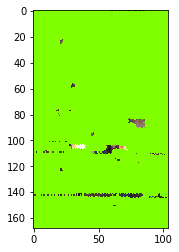

In [35]:
# crop
type(image)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image[cyclist_bbox.iymin:cyclist_bbox.iymax,cyclist_bbox.ixmin:cyclist_bbox.ixmax])

In [311]:
# vc_path = v2c_filepath
# cc_path = c2c_filepath
# print(vc_path)
# R_vc, T_vc = calib_velo2cam(vc_path)
# T_vc.shape

# mode = '02'

# P_ = calib_cam2cam(cc_path, mode)
# xyz_v, c_ = velo_points_filter(velo_points_with_ref, v_fov, h_fov)
# RT_ = np.concatenate((R_vc, T_vc),axis = 1)

# for i in range(xyz_v.shape[1]):
#         xyz_v[:3,i] = np.matmul(RT_, xyz_v[:,i])

# xyz_c = np.delete(xyz_v, 3, axis=0) 

# print(xyz_v)
# print(xyz_c)

# for i in range(xyz_c.shape[1]):
#         xyz_c[:,i] = np.matmul(P_, xyz_c[:,i])    
# print(xyz_c)
# print(xyz_c[::][2])
# scale_mat = xyz_c[::][2]

dist_lim [57.214115  57.312313  57.666176  ...  4.3818727  4.4036036  4.422075 ]
[98 98 98 ...  7  7  7]
122516
(6, 32062)


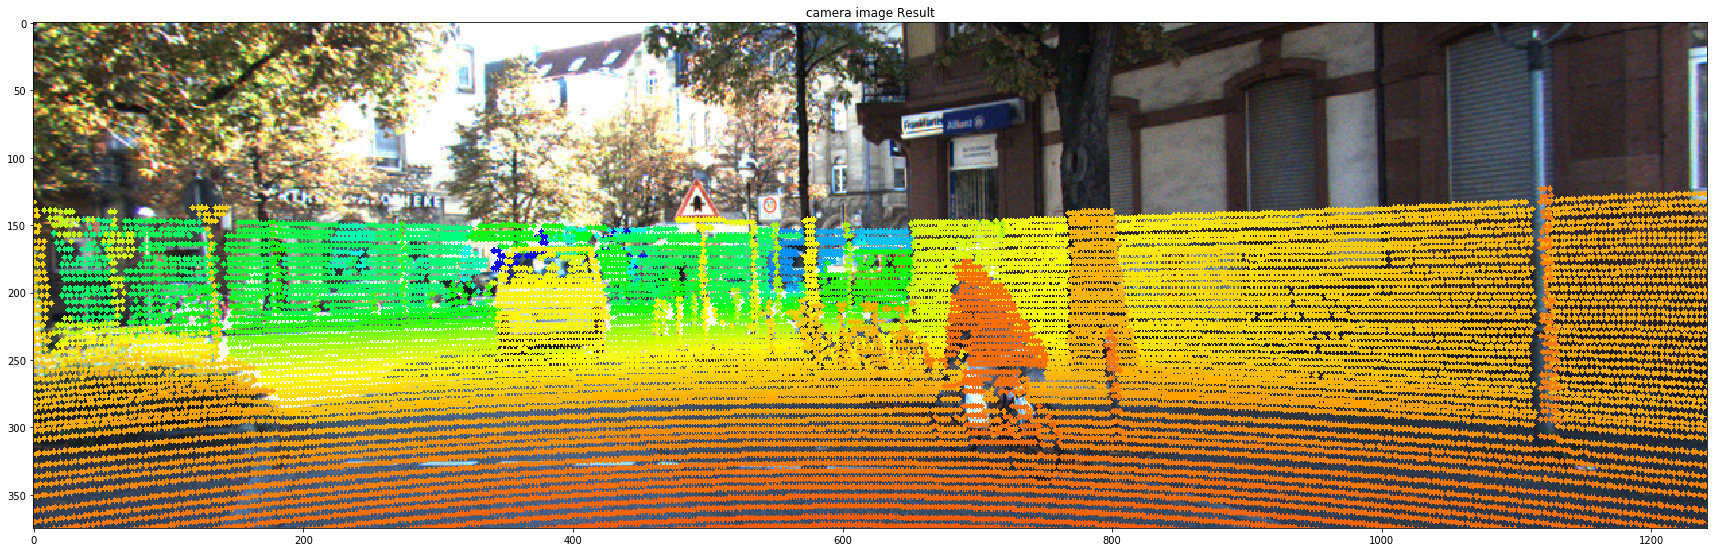

In [36]:
def print_projection_cv2(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

image_type = 'color' # 'grayscale' or 'color' image
mode = '00' if image_type == 'grayscale' else '02' # image_00 = 'grayscale image' , image_02 = 'color image'

image_c = cv2.imread(path +'image_'+ mode +'/data/0000000030.png')

ans, c_, ans_ri= velo3d_2_camera2d_points(velo_points_with_ref_id, v_fov=(-24.9, 2.0), h_fov=(-45,45), \
                               vc_path=v2c_filepath, cc_path=c2c_filepath, mode=mode)

image = print_projection_plt(points=ans_ri, color=c_, image=image_c)
print(c_)
# display result image
#plt.subplots(2,1, figsize = (13,3) )
f, ax = plt.subplots(1, 1, figsize=(30, 20))
ax.imshow(image)
ax.set_title("camera image Result")

# ax[0].imshow(image_c)
# ax[0].set_title("camera image Result")

# ax[1].imshow(image)
# ax[1].set_title("Velodyne points to camera image Result")
print(len(velo_points_with_ref))
print(ans_ri.shape)


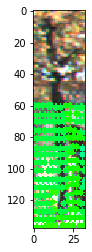

In [37]:
# crop
type(image)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image[tree2_bbox.iymin:tree2_bbox.iymax,tree2_bbox.ixmin:tree2_bbox.ixmax])

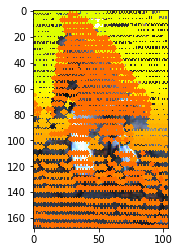

In [38]:
# crop
type(image)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image[cyclist_bbox.iymin:cyclist_bbox.iymax,cyclist_bbox.ixmin:cyclist_bbox.ixmax])

In [39]:
# statistics 
# relation between 2Dpoints and 3Dpoints
print(type(ans))
print(ans.shape)
print(ans[:, 0])
print(ans[:, 1])

# 2d points <-> 3d points

<class 'numpy.ndarray'>
(2, 32062)
[614.6082994  155.46721069]
[613.45747744 155.46590065]


In [40]:
velo_points.shape
velo_points[0]

array([5.7174e+01, 2.7000e-02, 2.1420e+00], dtype=float32)

In [41]:
type(ans)
ans.shape

(2, 32062)

## Save Video

In [52]:
import glob
import cv2

image_type = 'color' # 'grayscale' or 'color' image
mode = '00' if image_type == 'grayscale' else '02' # image_00 = 'grayscale image' , image_02 = 'color image'

lidar_points = glob.glob(path +'velodyne_points/data/*.bin')
image = glob.glob(path+'image_' + mode + '/data/*.png')

""" save result video """
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid = cv2.VideoWriter('projection.mp4', fourcc, 25.0, (width, height))

for i, point in enumerate (lidar_points):
    velo = load_from_bin(point)

    img = cv2.imread(str(image[i]))
    print((velo.shape))
    print(velo[1,2])
    ans, c_ = velo3d_2_camera2d_points(velo, v_fov=(-24.9, 2.0), h_fov=(-50,50), vc_path=v2c_filepath, cc_path=c2c_filepath, mode=mode)
                                       
    
    img = print_projection_cv2(points=ans, color=c_, image=img)
    vid.write(img)

print('video saved')
vid.release()

(122942, 3)
1.26


IndexError: index 3 is out of bounds for axis 1 with size 3

## Display Result Video

In [54]:
from IPython.display import clear_output

""" display video """
vid = cv2.VideoCapture("./projection.mp4")

while(True):
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    fig = plt.figure(figsize=(12,3))
    
    plt.title("Projection video result")
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()

In [2]:
#!/usr/bin/env python
"""
parse XML files containing tracklet info for kitti data base (raw data section)
(http://cvlibs.net/datasets/kitti/raw_data.php)
No guarantees that this code is correct, usage is at your own risk!
created by Christian Herdtweck, Max Planck Institute for Biological Cybernetics
  (christian.herdtweck@tuebingen.mpg.de)
updated by Alex Staravoitau
requires numpy!
example usage:
  import parseTrackletXML as xmlParser
  kittiDir = '/path/to/kitti/data'
  drive = '2011_09_26_drive_0001'
  xmlParser.example(kittiDir, drive)
or simply on command line:
  python parseTrackletXML.py
"""

# Version History:
# 20/3/17 Alex Staravoitau: updated for Python 3, cleaned up docstring comments, fixed tabulation; 
# 4/7/12 Christian Herdtweck: seems to work with a few random test xml tracklet files; 
#   converts file contents to ElementTree and then to list of Tracklet objects; 
#   Tracklet objects have str and iter functions
# 5/7/12 ch: added constants for state, occlusion, truncation and added consistency checks
# 30/1/14 ch: create example function from example code

from sys import argv as cmdLineArgs
from xml.etree.ElementTree import ElementTree
import numpy as np
from warnings import warn

STATE_UNSET = 0
STATE_INTERP = 1
STATE_LABELED = 2
stateFromText = {'0':STATE_UNSET, '1':STATE_INTERP, '2':STATE_LABELED}

OCC_UNSET = 255  # -1 as uint8
OCC_VISIBLE = 0
OCC_PARTLY = 1
OCC_FULLY = 2
occFromText = {'-1':OCC_UNSET, '0':OCC_VISIBLE, '1':OCC_PARTLY, '2':OCC_FULLY}

TRUNC_UNSET = 255  # -1 as uint8, but in xml files the value '99' is used!
TRUNC_IN_IMAGE = 0
TRUNC_TRUNCATED = 1
TRUNC_OUT_IMAGE = 2
TRUNC_BEHIND_IMAGE = 3
truncFromText = {'99':TRUNC_UNSET, '0':TRUNC_IN_IMAGE, '1':TRUNC_TRUNCATED, '2':TRUNC_OUT_IMAGE, '3': TRUNC_BEHIND_IMAGE}


class Tracklet(object):
    """ 
    Representation an annotated object track 
    Tracklets are created in function parseXML and can most conveniently used as follows:
    for trackletObj in parseXML(trackletFile):
    for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in trackletObj:
      ... your code here ...
    #end: for all frames
    #end: for all tracklets
    absoluteFrameNumber is in range [firstFrame, firstFrame+nFrames[
    amtOcclusion and amtBorders could be None
    You can of course also directly access the fields objType (string), size (len-3 ndarray), firstFrame/nFrames (int), 
    trans/rots (nFrames x 3 float ndarrays), states/truncs (len-nFrames uint8 ndarrays), occs (nFrames x 2 uint8 ndarray),
    and for some tracklets amtOccs (nFrames x 2 float ndarray) and amtBorders (nFrames x 3 float ndarray). The last two
    can be None if the xml file did not include these fields in poses
    """

    objectType = None
    size = None  # len-3 float array: (height, width, length)
    firstFrame = None
    trans = None   # n x 3 float array (x,y,z)
    rots = None    # n x 3 float array (x,y,z)
    states = None  # len-n uint8 array of states
    occs = None    # n x 2 uint8 array  (occlusion, occlusion_kf)
    truncs = None  # len-n uint8 array of truncation
    amtOccs = None    # None or (n x 2) float array  (amt_occlusion, amt_occlusion_kf)
    amtBorders = None    # None (n x 3) float array  (amt_border_l / _r / _kf)
    nFrames = None

    def __init__(self):
        """ 
        Creates Tracklet with no info set 
        """
        self.size = np.nan*np.ones(3, dtype=float)

    def __str__(self):
        """ 
        Returns human-readable string representation of tracklet object
        called implicitly in 
        print trackletObj
        or in 
        text = str(trackletObj)
        """
        return '[Tracklet over {0} frames for {1}]'.format(self.nFrames, self.objectType)

    def __iter__(self):
        """ 
        Returns an iterator that yields tuple of all the available data for each frame 
        called whenever code iterates over a tracklet object, e.g. in 
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in trackletObj:
          ...do something ...
        or
        trackDataIter = iter(trackletObj)
        """
        if self.amtOccs is None:
            return zip(self.trans, self.rots, self.states, self.occs, self.truncs,
                itertools.repeat(None), itertools.repeat(None), range(self.firstFrame, self.firstFrame+self.nFrames))
        else:
            return zip(self.trans, self.rots, self.states, self.occs, self.truncs,
                self.amtOccs, self.amtBorders, range(self.firstFrame, self.firstFrame+self.nFrames))
#end: class Tracklet


def parseXML(trackletFile):
    """ 
    Parses tracklet xml file and convert results to list of Tracklet objects
    :param trackletFile: name of a tracklet xml file
    :returns: list of Tracklet objects read from xml file
    """

    # convert tracklet XML data to a tree structure
    eTree = ElementTree()
    print('Parsing tracklet file', trackletFile)
    with open(trackletFile) as f:
        eTree.parse(f)

    # now convert output to list of Tracklet objects
    trackletsElem = eTree.find('tracklets')
    tracklets = []
    trackletIdx = 0
    nTracklets = None
    for trackletElem in trackletsElem:
        #print 'track:', trackletElem.tag
        if trackletElem.tag == 'count':
            nTracklets = int(trackletElem.text)
            print('File contains', nTracklets, 'tracklets')
        elif trackletElem.tag == 'item_version':
            pass
        elif trackletElem.tag == 'item':
            #print 'tracklet {0} of {1}'.format(trackletIdx, nTracklets)
            # a tracklet
            newTrack = Tracklet()
            isFinished = False
            hasAmt = False
            frameIdx = None
            for info in trackletElem:
                #print 'trackInfo:', info.tag
                if isFinished:
                    raise ValueError('more info on element after finished!')
                if info.tag == 'objectType':
                    newTrack.objectType = info.text
                elif info.tag == 'h':
                    newTrack.size[0] = float(info.text)
                elif info.tag == 'w':
                    newTrack.size[1] = float(info.text)
                elif info.tag == 'l':
                    newTrack.size[2] = float(info.text)
                elif info.tag == 'first_frame':
                    newTrack.firstFrame = int(info.text)
                elif info.tag == 'poses':
                    # this info is the possibly long list of poses
                    for pose in info:
                        #print 'trackInfoPose:', pose.tag
                        if pose.tag == 'count':     # this should come before the others
                            if newTrack.nFrames is not None:
                                raise ValueError('there are several pose lists for a single track!')
                            elif frameIdx is not None:
                                raise ValueError('?!')
                            newTrack.nFrames = int(pose.text)
                            newTrack.trans = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
                            newTrack.rots = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
                            newTrack.states = np.nan * np.ones(newTrack.nFrames, dtype='uint8')
                            newTrack.occs = np.nan * np.ones((newTrack.nFrames, 2), dtype='uint8')
                            newTrack.truncs = np.nan * np.ones(newTrack.nFrames, dtype='uint8')
                            newTrack.amtOccs = np.nan * np.ones((newTrack.nFrames, 2), dtype=float)
                            newTrack.amtBorders = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
                            frameIdx = 0
                        elif pose.tag == 'item_version':
                            pass
                        elif pose.tag == 'item':
                            # pose in one frame
                            if frameIdx is None:
                                raise ValueError('pose item came before number of poses!')
                            for poseInfo in pose:
                                #print 'trackInfoPoseInfo:', poseInfo.tag
                                if poseInfo.tag == 'tx':
                                    newTrack.trans[frameIdx, 0] = float(poseInfo.text)
                                elif poseInfo.tag == 'ty':
                                    newTrack.trans[frameIdx, 1] = float(poseInfo.text)
                                elif poseInfo.tag == 'tz':
                                    newTrack.trans[frameIdx, 2] = float(poseInfo.text)
                                elif poseInfo.tag == 'rx':
                                    newTrack.rots[frameIdx, 0] = float(poseInfo.text)
                                elif poseInfo.tag == 'ry':
                                    newTrack.rots[frameIdx, 1] = float(poseInfo.text)
                                elif poseInfo.tag == 'rz':
                                    newTrack.rots[frameIdx, 2] = float(poseInfo.text)
                                elif poseInfo.tag == 'state':
                                    newTrack.states[frameIdx] = stateFromText[poseInfo.text]
                                elif poseInfo.tag == 'occlusion':
                                    newTrack.occs[frameIdx, 0] = occFromText[poseInfo.text]
                                elif poseInfo.tag == 'occlusion_kf':
                                    newTrack.occs[frameIdx, 1] = occFromText[poseInfo.text]
                                elif poseInfo.tag == 'truncation':
                                    newTrack.truncs[frameIdx] = truncFromText[poseInfo.text]
                                elif poseInfo.tag == 'amt_occlusion':
                                    newTrack.amtOccs[frameIdx,0] = float(poseInfo.text)
                                    hasAmt = True
                                elif poseInfo.tag == 'amt_occlusion_kf':
                                    newTrack.amtOccs[frameIdx,1] = float(poseInfo.text)
                                    hasAmt = True
                                elif poseInfo.tag == 'amt_border_l':
                                    newTrack.amtBorders[frameIdx,0] = float(poseInfo.text)
                                    hasAmt = True
                                elif poseInfo.tag == 'amt_border_r':
                                    newTrack.amtBorders[frameIdx,1] = float(poseInfo.text)
                                    hasAmt = True
                                elif poseInfo.tag == 'amt_border_kf':
                                    newTrack.amtBorders[frameIdx,2] = float(poseInfo.text)
                                    hasAmt = True
                                else:
                                    raise ValueError('unexpected tag in poses item: {0}!'.format(poseInfo.tag))
                            frameIdx += 1
                        else:
                            raise ValueError('unexpected pose info: {0}!'.format(pose.tag))
                elif info.tag == 'finished':
                    isFinished = True
                else:
                    raise ValueError('unexpected tag in tracklets: {0}!'.format(info.tag))
            #end: for all fields in current tracklet

            # some final consistency checks on new tracklet
            if not isFinished:
                warn('tracklet {0} was not finished!'.format(trackletIdx))
            if newTrack.nFrames is None:
                warn('tracklet {0} contains no information!'.format(trackletIdx))
            elif frameIdx != newTrack.nFrames:
                warn('tracklet {0} is supposed to have {1} frames, but perser found {1}!'.format(trackletIdx, newTrack.nFrames, frameIdx))
            if np.abs(newTrack.rots[:,:2]).sum() > 1e-16:
                warn('track contains rotation other than yaw!')

            # if amtOccs / amtBorders are not set, set them to None
            if not hasAmt:
                newTrack.amtOccs = None
                newTrack.amtBorders = None

            # add new tracklet to list
            tracklets.append(newTrack)
            trackletIdx += 1

        else:
            raise ValueError('unexpected tracklet info')
    #end: for tracklet list items

    print('Loaded', trackletIdx, 'tracklets.')

    # final consistency check
    if trackletIdx != nTracklets:
        warn('according to xml information the file has {0} tracklets, but parser found {1}!'.format(nTracklets, trackletIdx))

    return tracklets
#end: function parseXM
if __name__ == "__main__":
  # cmdLineArgs[0] is 'parseTrackletXML.py'
  if len(cmdLineArgs) < 2:
    example()
  elif (len(cmdLineArgs) == 2) and (cmdLineArgs[1] == 'example'):
    example()
  else:
    example()
    #parseXML(*cmdLineArgs[1:])

NameError: name 'example' is not defined

In [ ]:
#%% interpolation
%gui qt
import numpy as np
from mayavi import mlab
from scipy.interpolate import griddata

print('test') 

# x,y,z = zip(*d[['X','Y','SIDD']].values)
# gx,gy = np.meshgrid(np.arange(0,71),np.arange(0,81),indexing='ij')
# gz = griddata(list(zip(x,y)),np.array(z),xi=(gx,gy),method='nearest')

 

# fig = mlab.figure(size=(800,600))
# su = mlab.surf(gx,gy,gz,colormap='Oranges',opacity=1,warp_scale='auto')
# mlab.axes(su,xlabel='X',ylabel='Y',zlabel='SIDD',color=(0.7,0.7,0.7))

In [1]:
import mayavi

In [2]:
print(mayavi.__version__)

4.7.1


In [ ]:
%gui qt
from mayavi import mlab

In [ ]:
# Create the data.
from numpy import pi, sin, cos, mgrid
dphi, dtheta = pi/250.0, pi/250.0
[phi,theta] = mgrid[0:pi+dphi*1.5:dphi,0:2*pi+dtheta*1.5:dtheta]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r = sin(m0*phi)**m1 + cos(m2*phi)**m3 + sin(m4*theta)**m5 + cos(m6*theta)**m7
x = r*sin(phi)*cos(theta)
y = r*cos(phi)
z = r*sin(phi)*sin(theta)

# View it.
from mayavi import mlab
s = mlab.mesh(x, y, z)
mlab.show()

/usr/local/lib/python3.6/dist-packages/traits/etsconfig/etsconfig.py:425: UserWarning: Environment variable "HOME" not set, setting home directory to /tmp
  % (environment_variable, parent_directory)
